## Article Recommendations for The Atlantic

The goal is to create a functionality that recommends articles from the Atlantic based on a selected article, using word embeddings generated by BERT.

In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 3.5 MB 29.8 MB/s 
     |████████████████████████████████| 1.2 MB 37.1 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 6.8 MB 38.9 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=db701bd58066e7bfffe4081f39d2db8d2486faae2e01a7d23a1710b88bc8d41a
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from sentence_transformers import SentenceTransformer
from scipy import spatial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
df = pd.read_pickle('atlantic_data.pkl')
df.shape

(29931, 11)

In [6]:
df.head()

,date,category,title,subtitle,author,author_bio,text,url,time_scraped,year,cleaned_text
0,2016-04-01,Daily,"The Atlantic Daily: March Jobs Report, Chicago...","The U.S. economy adds a modest 215,000 jobs, t...",Matt Ford and Rosa Inocencio Smith,Matt Ford is a former associate editor at The ...,What We’re Following: Marching Toward JobsThe...,https://www.theatlantic.com/newsletters/archiv...,2020-09-29 18:43:20.697674,2016,follow march toward jobsth economi ad modest j...
1,2016-04-01,Politics Daily,The Edge: In Like a Lion and Out With Jobs,NaN,Elaine Godfrey,Elaine Godfrey is a staff writer at The Atlant...,Today in One ParagraphPresident Obama advised...,https://www.theatlantic.com/politics/archive/2...,2020-09-29 18:43:37.002516,2016,today one paragraphpresid obama advis world le...
2,2016-04-01,Global,Hacking Elections in Latin America and Rapping...,The highlights from seven days of reading abou...,Jillian Kumagai,Jillian Kumagai is a former editorial fellow a...,The French Connection\r\nWilliam McCants and ...,https://www.theatlantic.com/international/arch...,2020-09-29 18:43:44.801143,2016,french connect william mccant christoph mesero...
3,2016-04-01,Politics,Bernie in the Bronx,Can Sanders stun Hillary Clinton in the state ...,Russell Berman,Russell Berman is a staff writer at The Atlant...,"BRONX, New York—Mercer Jabul sat quietly at t...",https://www.theatlantic.com/politics/archive/2...,2020-09-29 18:43:52.166631,2016,bronx new jabul sat quietli veri top hill mari...
4,2016-04-01,Global,Pitching Global Stories: A Freelancer’s Guide,"Send us your smart, original stories about wha...",The Editors,NaN,The Atlantic’s global coverage is driven by c...,https://www.theatlantic.com/international/arch...,2020-09-29 18:44:00.005706,2016,atlant global coverag driven curios world forc...


In [7]:
df = df.dropna(subset =['title', 'subtitle'])

In [71]:
df['category'].value_counts().head()

Politics    6335
Culture     3822
Ideas       3054
Global      2976
Science     2341
Name: category, dtype: int64

In [10]:
df['summary'] = df['title'] + '. ' + df['subtitle']

In [12]:
%%time
df['summary'][:100].apply(lambda x: embedder.encode(x))

CPU times: user 1.13 s, sys: 12.7 ms, total: 1.14 s
Wall time: 1.14 s


0      [-0.40941456, 0.17752996, 0.6309564, -0.835210...
2      [0.0506156, -0.11152493, 0.16775697, -0.695654...
3      [0.007312888, 0.841296, -0.89304894, -0.448234...
4      [-0.15356755, -0.6418701, -0.6025304, 0.028543...
5      [0.40855125, 0.13696228, -0.17827684, -1.31978...
                             ...                        
96     [-0.6304124, 0.0751489, -0.03086309, -0.544184...
97     [-0.08970968, -0.095841125, 0.4656065, -0.2623...
98     [0.10287264, -0.16799013, 0.005833856, -0.9918...
99     [0.24623367, 0.033282004, 0.4093637, -0.486336...
100    [0.20911404, 0.2351991, -0.4069581, -0.8680611...
Name: summary, Length: 100, dtype: object

In [72]:
%%time
df['summary_embedding'] = df['summary'].apply(lambda x: embedder.encode(x))

CPU times: user 5min 15s, sys: 1.44 s, total: 5min 16s
Wall time: 5min 23s


Visualization of embedded articles

In [119]:
%%time

# sample data for visualization purposes
df_sample = df.sample(5000, random_state=24)

# reshaping arrays
vectors = df_sample['summary_embedding'].values
vectors = np.stack(vectors)

# dimensionality reduction
tsne = TSNE(perplexity=30, random_state=27)
reduced_vecs = tsne.fit_transform(vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


CPU times: user 1min 24s, sys: 967 ms, total: 1min 25s
Wall time: 1min 26s


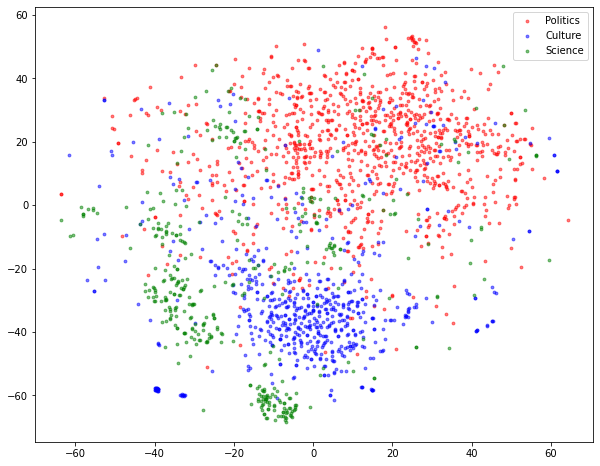

In [128]:
x = reduced_vecs[:, 0]
y = reduced_vecs[:, 1]

cat_color = {
    "Politics": "r",
    "Culture": "b",
    "Science": "g",
}

for cat, color in cat_color.items():
    is_cat = df_sample["category"] == cat

    x_cat = x[is_cat]
    y_cat = y[is_cat]

    plt.scatter(x_cat, y_cat, s=8, color=color, alpha=0.5, label=cat)

plt.legend()
figure = plt.gcf()
figure.set_size_inches(10, 8)
plt.show()

Creating a function to find similar articles based on cosine similarity between embeddings

In [129]:
def get_cos_similarity(embedding_1, embedding_2):
    return 1 - spatial.distance.cosine(embedding_1, embedding_2)


def find_similar_article(article_number, df, recommendations=3):
    embedding = df.loc[article_number]['summary_embedding']
    category = df.loc[article_number]['category']

    # series of scores 
    similarity_scores = df['summary_embedding'].apply(
        lambda x: get_cos_similarity(x, embedding)
        ).sort_values(ascending=False)
    
    # select top matches
    similar_articles_indices = similarity_scores.keys()[1:recommendations + 1]

    # printing results
    print(f'Original article (category: {category}): ')
    print(article_number, ': ', df.loc[article_number]['summary'], '\n')
    print('Similar articles: ')
    for i in similar_articles_indices:
        print(i, ': ', df.loc[i]['summary'])

Examples of recommendations for similar articles:

In [109]:
find_similar_article(24890, df)

Original article (category: Global): 
24890 :  America Is Not Going to Denuclearize North Korea. After the Kim regime’s third ICBM test, the Trump administration is still convinced that demanding disarmament is on the table. 

Similar articles: 
8570 :  The United States Is Still Trying to Sell North Korea on Denuclearization. Days before Donald Trump’s second summit with Kim Jong Un, an administration official admits that Kim may not be prepared to part with his nuclear weapons.
1818 :  North Korea Is Not Denuclearizing. The Trump administration shouldn’t get too excited about Kim Jong Un’s pledge to limit his weapons program.
23422 :  Donald Trump and the Threat of Nuclear War. The single most important question in this campaign: Which candidate is better equipped to manage the North Korean threat without triggering catastrophe?


In [118]:
find_similar_article(6783, df)

Original article (category: Culture): 
6783 :  Why The Rise of Skywalker Is So Frantic. The last installment of Disney’s Star Wars trilogy takes a storytelling approach diametrically opposed to what made the original series good. 

Similar articles: 
997 :  Star Wars: The Rise of Skywalker Might Spark an Old Fight. The trailer for the final film in Disney’s trilogy raises the notion that J. J. Abrams undid the twists of The Last Jedi. But that might be a bluff.
9295 :  Imagining a Better End to The Rise of Skywalker. Three fan-fiction writers dissect the divisive ending of the Disney trilogy—and the role of romance in the series.
18239 :  Beauty and the Beast: A Tale as Old as Time, Told Worse. Disney’s newest live-action remake can’t shake the legacy of the original masterpiece.


In [110]:
find_similar_article(18719, df)

Original article (category: Technology): 
18719 :  Self-Driving Cars Still Don't Know How to See. An Uber autonomous SUV killed a pedestrian. What does that say about the promise of self-driving technology? 

Similar articles: 
18710 :  Can You Sue a Robocar?. A pedestrian killed by a self-driving Uber in Tempe shows that the legal implications of autonomous cars are as important, if not more so, than the technology.
24075 :  How Driverless Cars Will Change the Feel of Cities. Autonomous vehicles promise safety and efficiency. But nobody knows what it will be like to live with them.
25166 :  What Drives a Driver. Gregg Katz, a taxi driver in Olathe, Kansas, talks about how he’s resisted the pull of ride-share apps like Uber and Lyft and why he think taxis are safer.
